# HOWTO: PACMan Model Training/Testing

The goal of this notebook is demonstrate the steps required to train a new multinomial, Naive Bayes classification model.
We will start with raw proposal data located in `proposal_data` directory and perform the following steps:

1. Proposal Scraping
  1. Extracting the Abstract and Scientific Justification sections from the .txtx files generated by the PDF to ascii converter
1. Text pre-processing
  1. Tokenization
  1. Filtering stop words
  1. Lemmatization
1. Training the model on our hand classified proposals
1. Testing the model on a secondary set of classified proposals

In [1]:
# native python
import os
import sys
cwd = os.getcwd()
pacman_directory = os.path.join('/',*cwd.split('/')[:-1])
sys.path.append(pacman_directory)

# open source packages
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split

# custom packages that are all in the github repo
from pacman2020 import PACManTrain, PACManPipeline
from utils.proposal_scraper import HSTProposalScraper
from utils.analyzer import PACManAnalyze

### 1. Proposal Scraping
We use the `HSTProposalScraper` class contained in the `proposal_scraper` module in the `utils` subpackage. We specify that we are scraping the proposals with the intention of using them for training and that we only want to scrape proposals in Cycle 24.
- By setting `for_training=True`, the software automatically looks for a file containing the hand classifications for the list of proposals and saves the scraped proposal information in an subdirectory of `~/PACMan_dist/training_data/`. In this example, the subdirectory will be named `training_corpus_cy24` and it will contain all of the training data for the given cycle, as well as the file containing the hand classifications.
- For the hand classifications, we adopt the following naming convention: cycle_CYCLENUMBER_hand_classifications.txt
   - e.g. cycle_24_hand_classifications.txt contains the hand classification of each proposal for cycle 24.
- Additionally, the file should only contain two columns, `proposal_num` and `hand_classification`. Below is an example snippet of what the file should look like:
    
    ```text
    proposal_num,hand_classification
    0001,stellar physics
    0002,stellar physics
            .
            . 
            .
    ```


In [2]:
pacman_scraper = HSTProposalScraper(for_training=True, cycles_to_analyze=[24, 25])
pacman_scraper.scrape_cycles()

INFO [proposal_scraper.scrape_cycles:519] /Users/nmiles/PACMan_dist/proposal_data/Cy24_proposals_txt/*txtx
INFO [proposal_scraper.scrape_cycles:522] Found 1093 proposals to scrape
Scraping Proposals: 100%|██████████| 1093/1093 [00:02<00:00, 404.28it/s]
INFO [proposal_scraper.scrape_cycles:519] /Users/nmiles/PACMan_dist/proposal_data/Cy25_proposals_txt/*txtx
INFO [proposal_scraper.scrape_cycles:522] Found 1208 proposals to scrape
Scraping Proposals: 100%|██████████| 1208/1208 [00:02<00:00, 469.27it/s]


In [3]:
!ls ../training_data/training_corpus_cy24/ | wc

    1094    1094   19708


### 2. Text Preprocessing (it could be a while... )
The `PACManTrain` class contained in the `pacman2020` module to is capable of performing all of the necessary preprocessing steps. Just like before, we specify the cycles we want to analyze and in this case it is just cycle 24.

In summary, this step is processing each input proposal with the `spaCy` NLP package to generate a `Doc` object, which is a sequence of tokens. Each token is an individual word that contains a variety of semantic information derived from the word and its context in a sentence. We leverage this information to filter out stop words, punctuations,  etc... This is the slowest step of the entire process and if needed, it can be improved using the multithreading behavior of `spaCy`.

The text preprocessing steps taken about 11 minutes per cycle.

In [4]:
pacman_training = PACManTrain(cycles_to_analyze=[24, 25])
pacman_training.read_training_data(parallel=False)

INFO [pacman2020.read_training_data:382] Reading in 1093 proposals...
Data Directory: /Users/nmiles/PACMan_dist/training_data/training_corpus_cy24
100%|██████████| 1093/1093 [11:39<00:00,  1.56it/s] 
INFO [pacman2020.preprocess:282] Total time for preprocessing: 11.665
INFO [pacman2020.read_training_data:382] Reading in 1208 proposals...
Data Directory: /Users/nmiles/PACMan_dist/training_data/training_corpus_cy25
100%|██████████| 1208/1208 [12:19<00:00,  1.63it/s]
INFO [pacman2020.preprocess:282] Total time for preprocessing: 12.328


For each proposal cycle in the `cycle_to_analyze` argument, the tokenizer will perform the necessary preprocessing steps and save the proposal number, text, cleaned text, filename, the hand classified science category, and the encoded value of the hand classified category. The results are stored in a pandas DataFrame in the `PACManTrain.proposal_data` attribute

In [29]:
def read_preprocessed(pacman_training):
    """Read in some preprocessed data for the sake of brevity"""
    pacman_training.proposal_data['cycle_24'] = pd.read_csv('./cycle_24_preprocessed.txt', header=0)
    pacman_training.proposal_data['cycle_25'] = pd.read_csv('./cycle_25_preprocessed.txt', header=0)
    return pacman_training
    

In [28]:
pacman_training.proposal_data['cycle_24'].head()

,text,cleaned_text,fname,proposal_num,hand_classification,encoded_hand_classification
0,This proposal seeks to use STIS with one orbit...,proposal seek stis orbit map disk titan wavele...,/Users/nmiles/PACMan_dist/training_data/traini...,954,solar system,3
1,Stellar mass loss rates are only known for 10 ...,stellar mass loss rate know sun like star meas...,/Users/nmiles/PACMan_dist/training_data/traini...,901,stellar physics,4
2,Local AGN were the first extragalactic objects...,local agn extragalactic object observe vacuum ...,/Users/nmiles/PACMan_dist/training_data/traini...,284,supermassive black holes and active galaxies,6
3,This is project is designed to explore the AGB...,project design explore agb rgb population lsb ...,/Users/nmiles/PACMan_dist/training_data/traini...,359,stellar populations and the ism,5
4,We have discovered a short period (18 minutes)...,discover short period minute far ultraviolet v...,/Users/nmiles/PACMan_dist/training_data/traini...,428,stellar physics,4


In [21]:
print('Found proposal information for:\n'+'\n'.join(pacman_training.proposal_data.keys())+'\n')

# Print the first 5 rows of the DataFrame for cycle 24
for key in pacman_training.proposal_data.keys():
    print(f"Displaying some information for {key}...")
    print(pacman_training.proposal_data[key].info())
    print('-'*58)

Found proposal information for:
cycle_24
cycle_25

Display some information for cycle_24...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1093 entries, 0 to 1092
Data columns (total 6 columns):
text                           1093 non-null object
cleaned_text                   1093 non-null object
fname                          1093 non-null object
proposal_num                   1093 non-null int64
hand_classification            1093 non-null object
encoded_hand_classification    1093 non-null int64
dtypes: int64(2), object(4)
memory usage: 59.8+ KB
None
----------------------------------------------------------
Display some information for cycle_25...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1208 entries, 0 to 1207
Data columns (total 6 columns):
text                           1208 non-null object
cleaned_text                   1208 non-null object
fname                          1208 non-null object
proposal_num                   1208 non-null int64
hand_classification    

In [6]:
first_row = pacman_training.proposal_data['cycle_24'].iloc[0]
msg = (
    f"HST Cycle 24 proposal number: {first_row['proposal_num']}\n"
    f"Hand Classification: {first_row['hand_classification']}\n"
    f"Raw Text:\n{first_row['text'][:100]}...\n"
    f"Cleaned Text:\n{first_row['cleaned_text'][:100]}...\n"

)
print(msg)
# print(pacman_training.proposal_data['cycle_24']['cleaned_text'].iloc[0]

HST Cycle 24 proposal number: 954
Hand Classification: solar system
Raw Text:
This proposal seeks to use STIS with one orbit each in 2017, 2018, and 2019 to map the full disk of ...
Cleaned Text:
proposal seek stis orbit map disk titan wavelength nm arc sec sampling spatial dimension observation...



#### Side note: pandas is cool.

We can use the resulting DataFrame to quickly examine the distribution of proposal categories for each cycles.

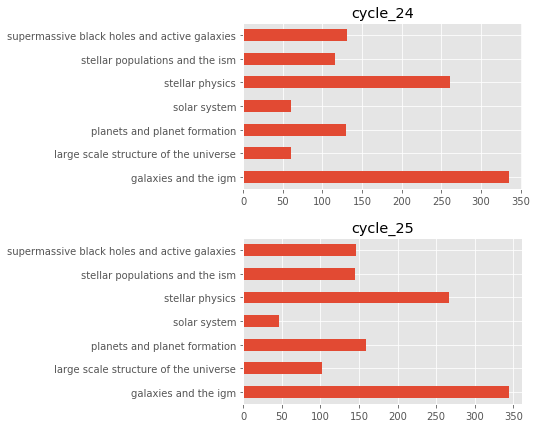

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5,7), gridspec_kw={'hspace':0.3})
for i, key in enumerate(pacman_training.proposal_data.keys()):
    proposal_categories = pacman_training.proposal_data[key]['hand_classification'].value_counts()
    proposal_categories.sort_index(inplace=True)
    ax = proposal_categories.plot.barh(label=key, ax=axes[i])
    ax.set_title(key)

### 3. Training

Now that we have all the proposal information loaded, we can train a classifier. When no model or vectorizer is specified, the software will use the default classifier (Multinomial Naive Bayes) and the default vectorizer (term frequency-inverse document frequency TFIDF). In theory, you can pass any combination of vectorizer and classifier that you want!

We test on cycle 25 because the original work was evaluated on cycle 24 data and these are the only two proposal cycles we have that have been hand classified. 

In [8]:
pacman_training.fit_model(pacman_training.proposal_data["cycle_25"])

In [9]:
pacman_training.model

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=10000,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True))],
         verbose=False)

### 4. Testing 
Finally, we evaluate the performance of the model we just trained. To do so, we use it to make predictions on a completely different proposal cycle that has also been hand classified. We compare the predictions to the hand classifications and voila.

In [10]:
pacman_training.apply_model(df=pacman_training.proposal_data["cycle_24"], training=True)

In [11]:
print("scikit-learn classification report")
print(
    classification_report(
        y_true = pacman_training.model_results['encoded_hand_classification'],
        y_pred = pacman_training.model_results['encoded_model_classification'],
        target_names=pacman_training.encoder.classes_
    )
)

scikit-learn classification report
                                              precision    recall  f1-score   support

                        galaxies and the igm       0.84      0.81      0.82       335
       large scale structure of the universe       0.49      0.57      0.53        60
                planets and planet formation       0.86      0.96      0.91       130
                                solar system       0.98      0.80      0.88        60
                             stellar physics       0.92      0.89      0.90       261
             stellar populations and the ism       0.74      0.78      0.76       116
supermassive black holes and active galaxies       0.89      0.91      0.90       131

                                    accuracy                           0.84      1093
                                   macro avg       0.82      0.82      0.81      1093
                                weighted avg       0.84      0.84      0.84      1093



Finally, we use the analysis class to compute our customized accuracy to allow for a comparison with the previous package.

In [13]:
pacman_analyzing = PACManAnalyze()
pacman_analyzing.encoder = pacman_training.encoder

In [14]:
pacman_analyzing.compute_accuracy_measurements(df=pacman_training.model_results)

Total number of galaxies and the igm proposals in top: 0.81
Total number of galaxies and the igm proposals in top_two: 0.15
Total number of galaxies and the igm proposals in misclassified: 0.04
------------------------------------------------------------
Total number of large scale structure of the universe proposals in top: 0.57
Total number of large scale structure of the universe proposals in top_two: 0.30
Total number of large scale structure of the universe proposals in misclassified: 0.13
------------------------------------------------------------
Total number of planets and planet formation proposals in top: 0.96
Total number of planets and planet formation proposals in top_two: 0.02
Total number of planets and planet formation proposals in misclassified: 0.02
------------------------------------------------------------
Total number of solar system proposals in top: 0.80
Total number of solar system proposals in top_two: 0.13
Total number of solar system proposals in misclassif

In [15]:
print(f"computed accuracy: {pacman_analyzing.computed_accuracy['top'].sum()/pacman_analyzing.computed_accuracy.sum().sum():.0%}")

computed accuracy: 84%


#### Saving the results and model

To provide a means of benchmarking various models, the classes have the functionality for saving the model results, as well as the trained model. By passing the `training=True` in the cell below, we are telling the code to save the results in the training subdirectory of the results directory. When `training=False` is passed, the results are written to the production directory. The intention here is to keep the results from training separate from the results when new proposals are analyzed.
   - ~/PACMan_dist/model_results/training/ 
   - ~/PACMan_dist/model_results/production/

In [18]:
pacman_training.save_model_results(fout='example_pacman_results_cycle24.txt', training=True)
pacman_training.save_model(fname='example_pacman_model.joblib')

INFO [pacman2020.save_model:454] Saving model and encoder information...


#### Testing multi-cycle cross validation

In [ ]:
pacman_training.model = None
pacman_training.fit_model(pacman_training.proposal_data["cycle_25"])

In [ ]:
pacman_training.apply_model(df=pacman_training.proposal_data["cycle_24"], training=True)

In [ ]:
pacman_training.model_results['fname'].iloc[0]

In [ ]:
print("scikit-learn classification report")
print(
    classification_report(
        y_true = pacman_training.model_results['encoded_hand_classification'],
        y_pred = pacman_training.model_results['encoded_model_classification'],
        target_names=pacman_training.encoder.classes_
    )
)

In [ ]:
def combine_proposals(pman):
    df1 = pman.proposal_data['cycle_24']
    df2 = pman.proposal_data['cycle_25']
    df = df2.append(df1, sort=True)
    return df

In [ ]:
def get_balanced_subset(df, proposal_counts):
    min_num_proposals = proposal_counts.min()
    data = {}
    for proposal_type in df['hand_classification'].unique():
        proposal_df = df[df['hand_classification'] == proposal_type]
        indices = np.random.randint(low=0, high=len(proposal_df), size=100)
        data[proposal_type] = proposal_df.iloc[indices]
    
    final_df = pd.DataFrame()
    for key in data.keys():
        final_df = final_df.append(data[key])
    return final_df

In [ ]:
total_dataset = combine_proposals(pacman_training)

In [ ]:
total_dataset.info()

In [ ]:
scorestotal = cross_val_score(
    training_pacman.model, 
    total_dataset['cleaned_text'], 
    total_dataset['encoded_hand_classification'], 
    cv=4, 
    scoring='f1_macro'
)
 

In [ ]:
total_proposal_counts = total_dataset['hand_classification'].value_counts()

In [ ]:
total_proposal_counts

In [ ]:
balanced_df = get_balanced_subset(df=total_dataset, proposal_counts=total_proposal_counts)

In [ ]:
len(balanced_df)

In [ ]:
scoresbalanced = cross_val_score(
    train_pacman.model, 
    balanced_df['cleaned_text'], 
    balanced_df['encoded_hand_classification'], 
    cv=4, 
    scoring='f1_macro'
)